In [1]:
#Import local modules
from Modules.Morphing import manage as morph

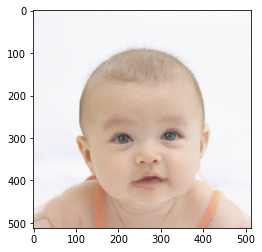

In [3]:
#morph.build_wrkdir()
morph.viewOutputImage()

In [3]:
morph.run_morph_exe()

C:\Users\steve\Desktop\Shodor\project\xray
DIR changed to  C:\Users\steve\Desktop\Shodor\project\xray\Modules\Morphing\Morph\src
Starting Example.exe...


KeyboardInterrupt: 